In [6]:
import os
from openai import OpenAI
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain.chains import LLMChain
from langgraph.graph import START, END, StateGraph, add_messages
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, BaseMessage
from langchain_core.runnables import Runnable
from collections.abc import Sequence
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage, SystemMessage, RemoveMessage
from collections.abc import Sequence
from typing import Literal, Annotated


In [7]:
# Use dotenv to load your environment variables (if running in Jupyter, `%dotenv` is fine)
from dotenv import load_dotenv
load_dotenv()  # loads .env file into environment variables
# Confirm your key is loaded
api_key = os.getenv("OPENAI_API_KEY")
if api_key is None:
    raise ValueError("OPENAI_API_KEY not found in environment variables")
print(f"OPENAI_API_KEY loaded: {'Yes' if api_key else 'No'}")

OPENAI_API_KEY loaded: Yes


### Import Relevant Classes and Functions

In [5]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage
from typing import Literal

### Define the State

In [8]:
class State(MessagesState):
    summary: str

In [9]:
test_state = State()

In [10]:
bool(test_state.get("summary", ""))

False

### Define the Nodes

In [11]:
chat = ChatOpenAI(model_name='gpt-4o-mini', temperature=0.3, max_tokens=255)

In [76]:
def ask_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_question:")
    
    question = "What is your question?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [77]:
def chatbot(state: State) -> State:
    
    print(f"\n-------> ENTERING chatbot:")
    for i in state["messages"]:
        i.pretty_print()
        
    system_message = f'''
    Here's a quick summary of what's been discussed so far:
    {state.get("summary", "")}
    
    Keep this in mind as you answer the next question.
    '''
    
    response = chat.invoke([SystemMessage(system_message)] + state["messages"])
    response.pretty_print()
    
    return State(messages = [response])

In [78]:
def ask_another_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_another_question:")
    
    question = "Would you like to ask one more question (yes/no)?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [ ]:
def summarize_and_delete_messages(state: State) -> State:
    print(f"\n-------> ENTERING trim_messages:")
    
    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"
        
    summary_instructions = f'''
Update the ongoing summary by incorporating the new lines of conversation below.  
Build upon the previous summary rather than repeating it so that the result  
reflects the most recent context and developments.

Previous Summary:
{state.get("summary", "")}

New Conversation:
{new_conversation}
'''
    
    print(summary_instructions)
    
    summary = chat.invoke([HumanMessage(summary_instructions)])
    
    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]]
    
    return State(messages = remove_messages, summary = summary.content)

### Define the Routing Function

In [80]:
def routing_function(state: State) -> Literal["summarize_and_delete_messages", "__end__"]:
    
    if state["messages"][-1].content == "yes":
        return "summarize_and_delete_messages"
    else:
        return "__end__"

### Define the Graph

In [81]:
graph = StateGraph(State)

In [82]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)
graph.add_node("summarize_and_delete_messages", summarize_and_delete_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function)
graph.add_edge("summarize_and_delete_messages", "ask_question")

In [83]:
graph_compiled = graph.compile()

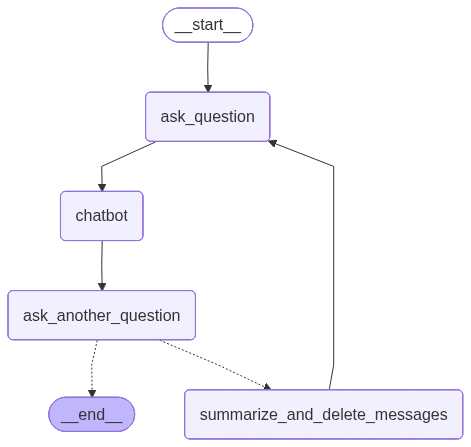

In [84]:
graph_compiled

### Test the Graph

In [85]:
graph_compiled.invoke(State(messages = []))


-------> ENTERING ask_question:
What is your question?

-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

where is haland from?
================================== Ai Message ==================================

Erling Haaland is from Norway. He was born in Leeds, England, but he represents the Norwegian national team in international football.

-------> ENTERING ask_another_question:
Would you like to ask one more question (yes/no)?

-------> ENTERING trim_messages:

Update the ongoing summary by incorporating the new lines of conversation below.  
Build upon the previous summary rather than repeating it so that the result  
reflects the most recent context and developments.


Previous Summary:


New Conversation:
ai: What is your question?

human: where is haland from?

ai: Erling Haaland is from Norway. He was born in Leed

{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='79c28a6b-5c85-4543-a19b-d728590cd866'),
  HumanMessage(content='where is messi from?', additional_kwargs={}, response_metadata={}, id='12c56637-f988-4504-af69-924301279e78'),
  AIMessage(content='Lionel Messi is from Argentina. He was born on June 24, 1987, in Rosario, a city in the province of Santa Fe. Messi is widely regarded as one of the greatest footballers of all time and has had an illustrious career, primarily with FC Barcelona before moving to Paris Saint-Germain (PSG) in 2021. Would you like to know more about Messi or any other player?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 212, 'total_tokens': 297, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens